In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Data loading


In [2]:
TRAIN_FILEPATH = os.path.join('..', 'input', 'train.csv')
TEST_FILEPATH = os.path.join('..', 'input', 'test.csv')

df_train = pd.read_csv(TRAIN_FILEPATH)
df_test = pd.read_csv(TEST_FILEPATH)

df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Data preprocessing

### Gestion des outliers

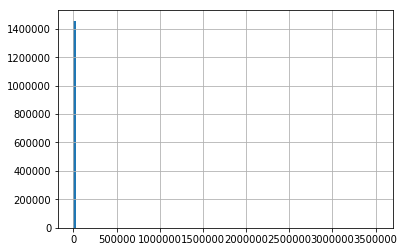

In [3]:
# Affichage du nombre de trajets en fonction du temps
df_train["trip_duration"].hist(bins=100)

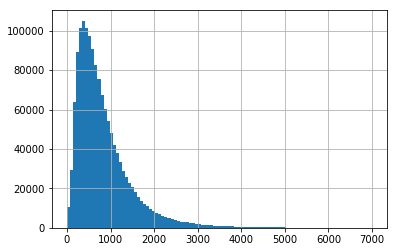

In [4]:
# Zoom sur les 7000 premières secondes
df_train.loc[df_train["trip_duration"] < 7000, "trip_duration"].hist(bins=100)

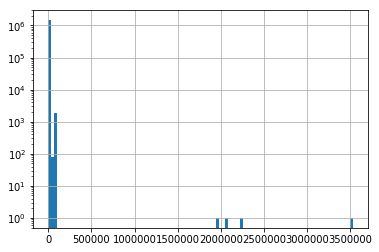

In [5]:
# Mise en exergue des outliers en utilisant le logarithme
df_train['trip_duration'].hist(bins=100, log=True);

In [6]:
# Durée moyenne d'un trajet (15 - 16 minutes)
df_train['trip_duration'].mean() / 60

15.991537882672764

Globalement, on constate que de nombreux trajets entre **300** et **800** secondes

Les trajets les plus courants se font entre **5 minutes et 15 minutes**

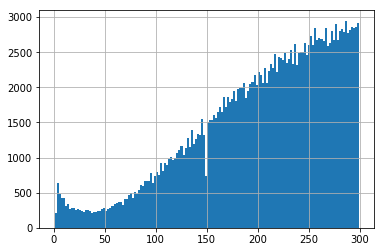

In [7]:
# On retrouve des trajets de moins d'une minute pouvant fausser le calcul de durée
df_train.loc[df_train['trip_duration'] < 300, 'trip_duration'].hist(bins=150)

In [8]:
# Suppression des trajets de moins de 2 minutes et trajets de plus d'1h30
df_train = df_train[df_train['trip_duration'] > 50] # Représente 2% du dataset
df_train = df_train[df_train['trip_duration'] < 3500]

### Gestion des données manquantes

In [9]:
# Affichage du nombre de données manquantes (is NaN)
df_train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Il n'ya aucune donnée manquante

In [10]:
# Affichage du nombre de données nulles
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Aucune donnée nulle

### Gestion des données dupliquées

In [11]:
# Suppression des lignes en double en filtrant par l'id
df_train_dupdropped = df_train.drop_duplicates(subset='id')

# Regarde combien de lignes ont étés supprimées
len(df_train) - len(df_train_dupdropped)

0

### Gestion des données catégoriques

In [12]:
# Gestion des données catégoriques
CAT_COL = "store_and_fwd_flag"
df_train[CAT_COL] = df_train[CAT_COL].astype('category').cat.codes
df_test[CAT_COL] = df_test[CAT_COL].astype('category').cat.codes

## Features engineering

### Features creation : Ajout d'une colonne distance

Création de la colonne "distance" qui contiendra la distance entre les coordonnées géographique de départ (pickup_latitude, pickup_longitude) et d'arrivée (dropoff_latitude, dropoff_longitude)

La formule donnée par Wikipédia pour calculer la distance à vol d'oiseau
$$M = 60\arccos \,[\sin(\varphi_A)\sin(\varphi_B) + \cos(\varphi_A)\cos(\varphi_B) \cos (\lambda_B - \lambda_A)]\,$$

In [13]:
import math
from geopy.distance import geodesic

def compute_distance(df):
    pointA = (df["pickup_latitude"], df["pickup_longitude"])
    pointB = (df["dropoff_latitude"], df["dropoff_longitude"])

    return geodesic(pointA, pointB).miles

In [14]:
# Calcul des distances sur le dataset train
df_train["distance"] = df_train.apply(compute_distance, axis=1)
df_train.head(20)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0.933406
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1.123849
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,3.964154
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,0.921886
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,0.737591
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,0,443,0.683275
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,0,341,0.824764
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,0,1551,3.553009
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,0,255,0.815587
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,0,1225,3.178194


In [15]:
# Calcul des distances également sur le dataset test
df_test["distance"] = df_test.apply(compute_distance, axis=1)
df_test.head(20)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,1.704336
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,1.712358
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,0.812202
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,3.272749
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,0.597601
5,id0668992,1,2016-06-30 23:59:30,1,-73.991302,40.749798,-73.980515,40.786549,0,2.598299
6,id1765014,1,2016-06-30 23:59:15,1,-73.978310,40.741550,-73.952072,40.717003,0,2.183113
7,id0898117,1,2016-06-30 23:59:09,2,-74.012711,40.701527,-73.986481,40.719509,0,1.853780
8,id3905224,2,2016-06-30 23:58:55,2,-73.992332,40.730511,-73.875618,40.875214,0,11.711224
9,id1543102,2,2016-06-30 23:58:46,1,-73.993179,40.748760,-73.979309,40.761311,0,1.131224


### Gestion / Suppression des distances erronées

Maintenant que nous avons calculé les distances, nous pouvons mieux traiter les données érronées

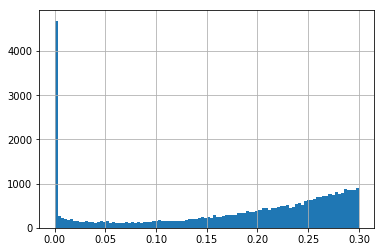

In [16]:
# Nombre de trajets à faible distance
df_train[df_train['distance'] < 0.3]['distance'].hist(bins=100)

On remarque des pics aux alentours de 0.

In [17]:
# Suppression des trajets à faible distance
df_train = df_train[df_train['distance'] > 0.3]

### Suppression des taxis en excès de vitesse

Sur l'état de New York, la vitesse maximal est de 75mph sur les grands axes. La vitesse ne devraient donc pas éxcéder celle-ci.

In [18]:
# Calcul des vitesses moyennes des taxis
speed = df_train['distance'] / ( df_train['trip_duration'] / 3600 )
df_train['speed'] = speed

df_train.head(20)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0.933406,7.385193
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1.123849,6.102349
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,3.964154,6.718905
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,0.921886,7.736110
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,0.737591,6.104201
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,0,443,0.683275,5.552575
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,0,341,0.824764,8.707185
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,0,1551,3.553009,8.246829
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,0,255,0.815587,11.514164
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,0,1225,3.178194,9.339997


In [19]:
# Nombre de taxis roulant à plus de 75mph
df_train[speed > 75].count()

id                    42
vendor_id             42
pickup_datetime       42
dropoff_datetime      42
passenger_count       42
pickup_longitude      42
pickup_latitude       42
dropoff_longitude     42
dropoff_latitude      42
store_and_fwd_flag    42
trip_duration         42
distance              42
speed                 42
dtype: int64

In [20]:
# Affichage de ces taxis
df_train[speed > 75].head(40)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed
13046,id3468323,1,2016-06-27 18:37:21,2016-06-27 18:43:16,1,-73.881195,40.882942,-73.965141,40.762486,0,355,9.404876,95.373386
25397,id1957624,2,2016-03-27 16:28:42,2016-03-27 16:32:25,1,-74.069908,40.739052,-74.157913,40.712528,0,223,4.969164,80.219682
125668,id0456393,1,2016-04-27 06:59:15,2016-04-27 07:03:40,1,-73.979668,40.748005,-73.865097,40.683315,0,265,7.490595,101.759031
176589,id1724402,1,2016-05-17 06:34:59,2016-05-17 06:36:27,1,-73.969231,40.798122,-73.999260,40.753773,0,88,3.441872,140.803870
182695,id1784326,2,2016-05-23 09:02:57,2016-05-23 09:04:16,5,-74.191154,40.654186,-74.170135,40.678253,0,79,1.994352,90.881883
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,0,792,770.817337,3503.715166
191997,id3892262,2,2016-03-13 15:19:35,2016-03-13 15:23:02,1,-73.975418,40.729980,-73.790306,40.643745,0,207,11.399422,198.250815
218935,id3333018,2,2016-06-22 11:40:46,2016-06-22 11:48:27,6,-73.679070,40.213837,-73.982361,40.767113,0,461,41.384304,323.174610
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354332,34.712234,-73.834923,32.181141,0,875,195.272499,803.406853
283102,id2778014,2,2016-01-17 16:43:09,2016-01-17 16:50:16,1,-73.997086,40.728924,-72.671150,40.614220,0,427,70.109248,591.084998


In [21]:
# Suppression de ces taxis
df_train = df_train[speed < 75]

### Features creation : Ajout des colonnes pickup_hour et pickup_day

Création de la colonne "pickup_hour" et "pickup_day" car selon les jours et les heures (jours de travail, matin à 8h ou soir à 22h), le temps d'un trajet peut varier suivant le traffic routier

In [22]:
df_train["pickup_hour"] = pd.to_datetime(df_train.pickup_datetime).dt.hour
df_train["pickup_day"] = pd.to_datetime(df_train.pickup_datetime).dt.dayofweek

df_test["pickup_hour"] = pd.to_datetime(df_test.pickup_datetime).dt.hour
df_test["pickup_day"] = pd.to_datetime(df_test.pickup_datetime).dt.dayofweek

df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed,pickup_hour,pickup_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0.933406,7.385193,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1.123849,6.102349,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,3.964154,6.718905,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,0.921886,7.736110,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,0.737591,6.104201,13,5


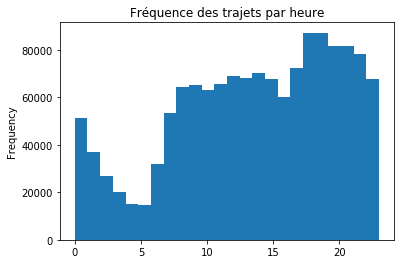

In [23]:
# Nombre de trajets par heure
df_train["pickup_hour"].plot.hist(bins=24, title="Fréquence des trajets par heure")

Il semble y avoir moins de trajets très tôt en matinée

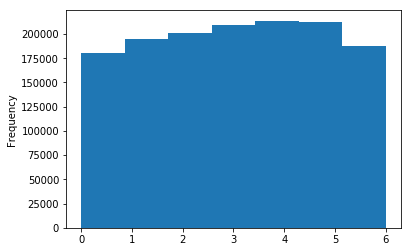

In [24]:
# Fréquence des trajets par jour
df_train['pickup_day'].plot.hist(bins=7)

La variation en fonction du jour est cependant plus faible. Cependant on remarque une faible chute les Samedi (6) et dimanche (0)

Je vérifie que le traitement n'a pas généré de valeurs nulles

In [25]:
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
distance              0
speed                 0
pickup_hour           0
pickup_day            0
dtype: int64

In [26]:
df_test.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
distance              0
pickup_hour           0
pickup_day            0
dtype: int64

### Features selection

In [27]:
FEATURES = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "pickup_hour", "pickup_day", "distance"]
TARGET = 'trip_duration'

In [28]:
X_train = df_train[FEATURES]
Y_train = df_train[TARGET]

X_test = df_test[FEATURES]

X_train.shape, Y_train.shape

((1399459, 7), (1399459,))

## Model Selection

In [29]:
from sklearn.ensemble import RandomForestRegressor

m1 = RandomForestRegressor(n_estimators=15)
m1.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Validation

In [30]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(m1, X_train, Y_train, cv=5, scoring='neg_mean_squared_log_error')
cv_scores

array([-0.10716138, -0.10679686, -0.10684343, -0.10709805, -0.10680383])

## Prediction

In [31]:
predictions = m1.predict(X_test)
predictions[:10]

array([ 783.53333333,  605.6       ,  480.8       , 1004.73333333,
        476.46666667,  982.8       , 1284.4       ,  736.4       ,
       2077.26666667,  511.06666667])

### Submission

In [32]:
submission = pd.DataFrame({'id': df_test['id'], 'trip_duration': predictions})
submission.to_csv('submission.csv', index=False)

submission.head()

,id,trip_duration
0,id3004672,783.533333
1,id3505355,605.600000
2,id1217141,480.800000
3,id2150126,1004.733333
4,id1598245,476.466667
